# Create SparkSession, import packages

In [1]:
from pyspark.sql import SparkSession, SQLContext
import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, _convert_to_vector, VectorUDT
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator

from pyspark.mllib.linalg import Vectors, SparseVector
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.tree import RandomForest
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
import scipy.sparse

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("xor") \
    .config("spark.executor.memory", '4g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'4g') \
    .getOrCreate()

sc = spark.sparkContext
sqlCtx = SQLContext(sc)

# Read in Data

In [2]:
#read in with pandas first since the data is weirdly delimited
#train features
pandas_train_features = pd.read_csv("Data/X_train.txt", sep='\s+',header=None)
#conversion to spark df
df_train_features = sqlCtx.createDataFrame(pandas_train_features)

In [3]:
#training labels
pandas_train_labels = pd.read_csv("Data/y_train.txt", sep='\s+',header=None)
pandas_train_labels.columns=['position']
#conversion to spark df
df_train_labels = sqlCtx.createDataFrame(pandas_train_labels)

In [4]:
#test features
pandas_test_features = pd.read_csv("Data/X_test.txt", sep='\s+',header=None)
#conversion to spark df
df_test_features = sqlCtx.createDataFrame(pandas_test_features)

In [5]:
#test labels
pandas_test_labels = pd.read_csv("Data/y_test.txt", sep='\s+',header=None)
pandas_test_labels.columns=['position']
#conversion to spark df
df_test_labels = sqlCtx.createDataFrame(pandas_test_labels)

In [6]:
#header
pandas_header = pd.read_csv("Data/features.txt", sep='\s+',header=None)
#conversion to spark df. this has an index column, so we deselect it
df_header = sqlCtx.createDataFrame(pandas_header)


In [7]:
#pull out the header names. "id" is an identifier, and "position" is the label
df_header_names = ["id"] + df_header.select('1').rdd.map(lambda row : row[0]).collect() + ["position"]

In [8]:
#reading subject number in
panda_sub_train=pd.read_csv("Data/subject_train.txt",sep='\s+',header=None)
panda_sub_train.columns=['id']

panda_sub_test=pd.read_csv("Data/subject_test.txt",sep='\s+',header=None)
panda_sub_test.columns=['id']
df_sub_train=sqlCtx.createDataFrame(panda_sub_train)
df_sub_test=sqlCtx.createDataFrame(panda_sub_test)

# Merge header, id, features, and label, and split into training/test set

In [9]:
#merge x feature files with subject id
merged_train=pd.merge(panda_sub_train,pandas_train_features, right_index=True, left_index=True)
merged_test=pd.merge(panda_sub_test,pandas_test_features, right_index=True, left_index=True)

#transform to df
df_merged_train_features=sqlCtx.createDataFrame(merged_train)
df_merged_test_features=sqlCtx.createDataFrame(merged_test)

In [10]:
#merge train files with subject id, testing and training sets
#Dennis
#pd.concat([df_a, df_b], axis=1) example
mergetrain=pd.concat([merged_train,pandas_train_labels],axis=1)
mergetest=pd.concat([merged_test,pandas_test_labels],axis=1)

#combine train and test to resplit into 80-20
combine=pd.concat([mergetrain,mergetest],axis=0)

In [11]:
#convert into SparkDF
df_complete_merge=sqlCtx.createDataFrame(combine)

#resplit data to 80:20
(train_data, test_data)=df_complete_merge.randomSplit(seed=314,weights=[0.8,0.2])

In [12]:
#add headers
#note: train_data is what we're using as our "primary" dataset
train_data = train_data.toDF(*df_header_names)

test_data = test_data.toDF(*df_header_names)


In [13]:
##remove bandEnergy columns because they are not unique, not easily interpretable 
    #They represent the "intensity" of activity in the frequency domain, but this data is captured by comparing the time and frequency activity data.

# first, we pull out the columns that have bandsEnergy in them
train_band_cols = [s for s in train_data.columns if 'bandsEnergy' in s]
test_band_cols = [s for s in test_data.columns if 'bandsEnergy' in s]

# then, we pull out these columns out of the data
train_data = train_data.select([a for a in train_data.columns if a not in train_band_cols])
test_data = test_data.select([a for a in test_data.columns if a not in test_band_cols])


In [14]:
#new header row, with the removed bandsEnergy columns
feature_header = [s for s in train_data.columns if s not in ["id", "position"]]

In [15]:
#split into features (x) and labels (y)
    #note that the label is the "position" column
train_x = train_data.drop("position")
train_y = train_data.select("position") 

test_x = test_data.drop("position")
test_y = test_data.select("position")

In [16]:
train_x.show(5)

+---+-----------------+--------------------+-----------------+----------------+--------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+--------------------+----------------+----------------+--------------+-------------------+--------------------+-------------------+----------------+----------------+----------------+--------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+--------------------------+--------------------------+--------------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------

# Data exploration (looking for NA, summary stats, counts, )

In [17]:
#check for missing values
from pyspark.sql.functions import isnan, when, count, col
train_x.select([count(when(isnan(c), c)).alias(c) for c in train_x.columns]).show()

#we note that there are no missing values


+---+-----------------+-----------------+-----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+--------------+-------------------+-------------------+-------------------+----------------+----------------+----------------+--------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+--------------------------+--------------------------+--------------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------

In [18]:
#getting an idea of what the data looks like by computing a summary
train_x.select(train_x.columns[1:5]).describe().show()

+-------+-------------------+--------------------+--------------------+-------------------+
|summary|  tBodyAcc-mean()-X|   tBodyAcc-mean()-Y|   tBodyAcc-mean()-Z|   tBodyAcc-std()-X|
+-------+-------------------+--------------------+--------------------+-------------------+
|  count|               8214|                8214|                8214|               8214|
|   mean| 0.2741672598077674|-0.01782892635303...|-0.10915220003803862|-0.6073341095553922|
| stddev|0.06700302726138603| 0.03591625355986128| 0.05274787651955511|  0.437108344479308|
|    min|               -1.0|         -0.68409659|         -0.92598834|               -1.0|
|    max|                1.0|                 1.0|                 1.0|                1.0|
+-------+-------------------+--------------------+--------------------+-------------------+



In [19]:
#look at the data by seeing how many rows there are
ds = pd.DataFrame(index=[1], columns=['train_features_obs','train_labels_obs','test_features_obs','test_labels_obs', 'header_obs'])
ds['train_features_obs'] = df_train_features.count()
ds['train_labels_obs'] = df_train_labels.count()
ds['test_features_obs'] = df_test_features.count()
ds['test_labels_obs'] = df_test_labels.count()
ds['header_obs']= df_header.count()
ds=sqlCtx.createDataFrame(ds)
ds.show()                #created data frame to show how many obs in each file
                        #makes it easier to see under df, -Kevin


+------------------+----------------+-----------------+---------------+----------+
|train_features_obs|train_labels_obs|test_features_obs|test_labels_obs|header_obs|
+------------------+----------------+-----------------+---------------+----------+
|              7352|            7352|             2947|           2947|       561|
+------------------+----------------+-----------------+---------------+----------+



# Scale the Data

In [18]:
# Vectorize the data for modeling
#exclude 1st column (id) and last column (position)
assembler = VectorAssembler(inputCols = train_data.columns[1:-1], outputCol = "features")
train_vectorized = assembler.transform(train_data)
train_vectorized = train_vectorized.select("id","features", "position")

test_vectorized = assembler.transform(test_data)
test_vectorized = test_vectorized.select("id", "features", "position")

In [19]:
# scale the features
    # we don't scale mean, since our data is not all on the same scale
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=False)

scalerModel_train = scaler.fit(train_vectorized)

#change train_x_vectorized to also be scaled
#comments are if we want to rename the column to just be "features" instead of "scaledFeatures"
train_vectorized = scalerModel_train.transform(train_vectorized)#.drop('features')\
                     #.withColumnRenamed('scaledFeatures', 'features')
test_vectorized = scalerModel_train.transform(test_vectorized)

# Trying PCA

In [20]:
# PCA For scree plot
pca_10 = PCA(k=10, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_train_10 = pca_10.fit(train_vectorized)

#compute the pve
train_pve_10 = pca_train_10.explainedVariance.cumsum()

#map data to the space mapped by the first 10 pc
train_10 = pca_train_10.transform(train_vectorized).select("pcaFeatures", "position")

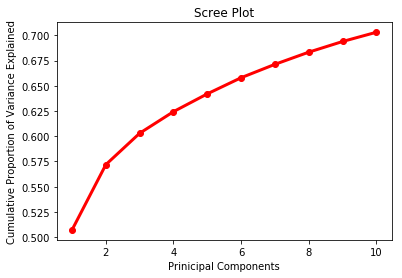

In [23]:
# Scree Plot

number_of_pc = np.arange(1,11)
plt.plot(number_of_pc, train_pve_10, 'ro-', linewidth = 3)
plt.title('Scree Plot')
plt.xlabel("Prinicipal Components")
plt.ylabel("Cumulative Proportion of Variance Explained")
plt.show()

In [24]:
# PCA for plotting and cluster analysis
pca_2 = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_train_2 = pca_2.fit(train_vectorized)

#compute the pve
train_pve_2 = pca_train_2.explainedVariance.cumsum()

#map data to the space mapped by the first 5 pc
train_2 = pca_train_2.transform(train_vectorized).select("pcaFeatures")

In [25]:
train_pc1 = np.array(train_2.rdd.map(lambda x: (x[0][0])).collect())
train_pc2 = np.array(train_2.rdd.map(lambda x: (x[0][1])).collect())

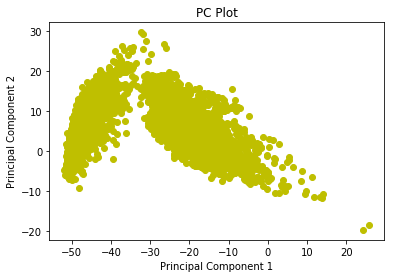

In [26]:
#plot the first pc on x axis, second pc on y axix
plt.scatter(train_pc1,train_pc2,c='y')
plt.title('PC Plot')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [27]:
#create kmeans.
kmeans6 = KMeans().setK(6).setSeed(1)
kmeans2 = KMeans().setK(2).setSeed(1)

In [28]:
#kmeans needs a column named features, so we rename them
train_2 = train_2.withColumnRenamed('pcaFeatures', 'features')
train_2kmeans6 = kmeans6.fit(train_2.select('features'))
train_2kmeans2 = kmeans2.fit(train_2.select('features'))

In [29]:
#apply the model to the data and extract the data
train_2_cluster6_w_pred = train_2kmeans6.transform(train_2)
train_2cluster6_label = np.array(train_2_cluster6_w_pred.select('prediction').rdd.map(lambda x: x[0]).collect())

train_2_cluster2_w_pred = train_2kmeans2.transform(train_2)
train_2cluster2_label = np.array(train_2_cluster2_w_pred.select('prediction').rdd.map(lambda x: x[0]).collect())

In [32]:
#avg silhouette is a measure of how closely the data matches its assigned cluster, and its closest neighboring cluster.
    #values range from -1 to 1, where 1 is best, and -1 is worst.

#cluster_silhouettes will hold the avg silhouette values for k = 2,3,...,10 clusters.
cluster_silhouettes = []
for i in range(2,11):
    kmeans = KMeans().setK(i).setSeed(1)
    train_w_kmeans = kmeans.fit(train_2.select("features"))
    train_w_cluster = train_w_kmeans.transform(train_2)
    cluster_eval= ClusteringEvaluator(predictionCol="prediction")
    silhouette = cluster_eval.evaluate(train_w_cluster)
    cluster_silhouettes.append((i, silhouette))

In [33]:
cluster_silhouettes
#this suggests that 2 is the ideal number of clusters, which matches our expectation.

[(2, 0.87437454148152),
 (3, 0.758721098676547),
 (4, 0.6631901942651887),
 (5, 0.6440723874396136),
 (6, 0.6095295213807399),
 (7, 0.5758151777811968),
 (8, 0.5500536877285729),
 (9, 0.5861399195617824),
 (10, 0.5519265723169959)]

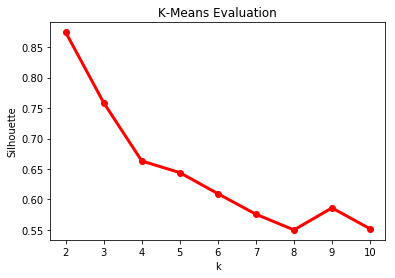

In [34]:
#eval plot for kmeans
k = np.arange(2,11)
silhouette = [sil[1] for sil in cluster_silhouettes]
plt.plot(k, silhouette, 'ro-', linewidth = 3)
plt.title('K-Means Evaluation')
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

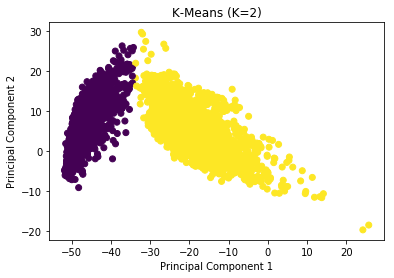

In [35]:
#plot the pc data based on the cluster assignments (k = 2)
plt.scatter(train_pc1,train_pc2,c=train_2cluster2_label)
plt.title('K-Means (K=2)')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

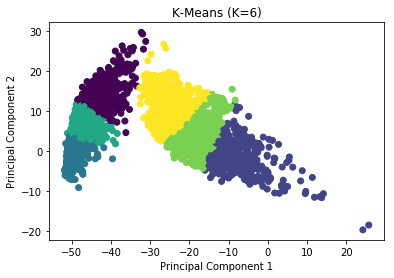

In [36]:
#plot the pc data based on the cluster assignments (k = 6)
plt.scatter(train_pc1,train_pc2,c=train_2cluster6_label)
plt.title('K-Means (K=6)')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

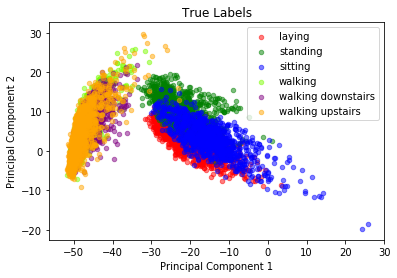

In [37]:
#plot the pc data based on true labels

cdict = {1: 'red', 2: 'green', 3: 'blue', 4: 'lawngreen', 5: 'purple', 6: 'orange'}
labeldict = {1: 'laying', 2: 'standing', 3: 'sitting', 4: 'walking', 5: 'walking downstairs', 6: 'walking upstairs'}
train_2_labels = pca_train_2.transform(train_vectorized).select("position").rdd.map(lambda x : x[0]).collect()

fig, ax = plt.subplots()
for g in np.unique(train_2_labels):
    ix = np.where(train_2_labels == g) 
    ax.scatter(train_pc1[ix], train_pc2[ix], c = cdict[g], label = labeldict[g], s = 20, alpha = 0.5)
ax.legend()
plt.title("True Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [38]:
#computing within set sum of squares if we want it
    # I'm using the silhouette metric instead.
    
#wssse = train_2kmeans2.computeCost(train_2.select('features'))
#print("Within Set Sum of Squared Errors = " + str(wssse))

In [39]:
#this function can be used to evaluate our models: it will return the misclassification error by class
def confusion_matrix(df):
    misclass = []
    for i in range(1,7):
        truth = df.select("position").filter("position == %g" %i).count()
        true_pos = df.select("position", "prediction").filter("position == %g" %i).filter("prediction == %g" %i).count()
        misclass.append((labeldict[i],1.0 - true_pos/truth))
    
    return misclass

# Random Forest (on whole training set)

In [40]:
#random forest parameters
rfSetup_full = RandomForestClassifier(labelCol="position", featuresCol="scaledFeatures", numTrees=1000,seed = 1)


In [41]:
#fit the model on the full training set
rfModel_full = rfSetup_full.fit(train_vectorized) 

In [42]:
#run the model on the full training set
train_full_pred_rf = rfModel_full.transform(train_vectorized)

In [43]:
#create evaluator for the rf models
evaluator_rf = MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="accuracy")


In [44]:
#compute training error
train_full_accuracy_rf = evaluator_rf.evaluate(train_full_pred_rf)
print("Training Error = %g" % (1.0 - train_full_accuracy_rf))

Training Error = 0.0723156


In [45]:
#run the model on the full test set and compute test error
test_full_pred_rf = rfModel_full.transform(test_vectorized)
test_accuracy_rf = evaluator_rf.evaluate(test_full_pred_rf)
print("Test Error = %g" % (1.0 - test_accuracy_rf))


Test Error = 0.0829736


In [46]:
f1_score=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="f1")
f1 = f1_score.evaluate(train_full_pred_rf)
print("Train Set F1 Score = %g" % (f1))

recall_score=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="weightedRecall")
recall = recall_score.evaluate(train_full_pred_rf)
print("Train Set Recall Score = %g" % (recall))

precision_score=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_score.evaluate(train_full_pred_rf)
print("Train Set Precision Score = %g" % (precision))

base_rf_f1= f1
base_rf_recall= recall
base_rf_precision = precision

Train Set F1 Score = 0.927357
Train Set Recall Score = 0.927684
Train Set Precision Score = 0.928312


In [47]:
#pulling out feature importance from the model, which is the average across trees in the forest
    #normalizes the features to sum to 1
    # note that if all features were equally powerful predictors
        #each would have a feature importance of 0.00229885, since this model has 435 predictors
feature_importance = rfModel_full.featureImportances

In [48]:
#changing the indices from numbers to be the name of the header
feature_importance.indices = feature_header

In [49]:
#turns the sparse vector dictionary form to a tuple, with (index, importance)
feature_importance = list(zip(feature_importance.indices, feature_importance.values))

In [50]:
#sort the values so the highest shows up first
importance_values = sorted(feature_importance, key = lambda tup: tup[1], reverse=True)

In [51]:
#this gives the 50 most important variables according to our random forest model.
importance_values[0:50]

[('tGravityAcc-mean()-X', 0.03930005792390602),
 ('tGravityAcc-energy()-X', 0.03633463297803073),
 ('tGravityAcc-max()-X', 0.03615632866535244),
 ('tGravityAcc-min()-X', 0.034258135669198386),
 ('angle(X,gravityMean)', 0.03316345199109367),
 ('angle(Y,gravityMean)', 0.024350964233609905),
 ('tGravityAcc-min()-Y', 0.022530946813065843),
 ('tGravityAcc-mean()-Y', 0.020952984006897483),
 ('tGravityAcc-max()-Y', 0.02041814466337892),
 ('tGravityAcc-energy()-Y', 0.015484047653672176),
 ('fBodyAccMag-mad()', 0.012539522511055346),
 ('fBodyAccMag-energy()', 0.012064719951249374),
 ('fBodyAcc-energy()-X', 0.011605493274223609),
 ('tBodyAcc-max()-X', 0.011576515010620304),
 ('tGravityAccMag-std()', 0.011523465010345263),
 ('tBodyAcc-std()-X', 0.010906266771446337),
 ('tGravityAcc-arCoeff()-Y,2', 0.010313946471893617),
 ('fBodyAccMag-std()', 0.01021164397022723),
 ('angle(Z,gravityMean)', 0.010177957888718798),
 ('tGravityAcc-arCoeff()-Y,3', 0.009978194006727314),
 ('tGravityAcc-min()-Z', 0.0099

# Random Forest (on 10 pc)

In [52]:
# training a model on the training set
rfSetup_pca = RandomForestClassifier(labelCol="position", featuresCol="pcaFeatures", numTrees=1000, seed = 1)
rfModel_10pc = rfSetup_pca.fit(train_10)

In [53]:
#run model on training set
train_10pc_pred_rf = rfModel_10pc.transform(train_10)

In [54]:
#evaluate training model
train_10pc_accuracy_rf = evaluator_rf.evaluate(train_10pc_pred_rf)
print("Training Error with 10 pc = %g" % (1.0 - train_10pc_accuracy_rf))

Training Error with 10 pc = 0.178232


In [55]:
# Create a pipeline to go through all of these steps!


rf_pipeline_pca = Pipeline(stages=[assembler, scaler, pca_10, rfSetup_pca])

In [56]:
rf_model_pca = rf_pipeline_pca.fit(train_data)

In [57]:
#run the pipeline on the test data
test_10pc_pred_rf = rf_model_pca.transform(test_data)

In [58]:
#evaluate the performance on the test set
test_10pc_accuracy_rf = evaluator_rf.evaluate(test_10pc_pred_rf)
print("Testing Error with 10 pc = %g" % (1.0 - test_10pc_accuracy_rf))

Testing Error with 10 pc = 0.177458


In [59]:
#look at error by class
confusion_matrix(test_10pc_pred_rf)

[('laying', 0.12835820895522387),
 ('standing', 0.1476510067114094),
 ('sitting', 0.19932432432432434),
 ('walking', 0.44817927170868344),
 ('walking downstairs', 0.13315926892950392),
 ('walking upstairs', 0.03125)]

In [60]:
#Scores for Random Forest on 10 PC
f1_score=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="f1")
f1 = f1_score.evaluate(test_10pc_pred_rf)
print("Random Forest,10 PC Test Set F1 Score = %g" % (f1))

recall_score=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="weightedRecall")
recall = recall_score.evaluate(test_10pc_pred_rf)
print("Random Forest, 10 PC Test Set Recall Score = %g" % (recall))

precision_score=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_score.evaluate(test_10pc_pred_rf)
print("Random Forest, 10 PC Test Set Precision Score = %g" % (precision))


rf_w_10pcscores_f1 = f1
rf_w_10pcscores_recall = recall
rf_w_10pcscores_precision = precision


Random Forest,10 PC Test Set F1 Score = 0.818685
Random Forest, 10 PC Test Set Recall Score = 0.822542
Random Forest, 10 PC Test Set Precision Score = 0.824142


# Multinomial Logistic Regression

In [30]:
#New classifier -Kevin, Defualt version
#code from spark documentation
from pyspark.ml.classification import LogisticRegression



lr_basic = LogisticRegression(featuresCol='scaledFeatures', labelCol = 'position', maxIter=10, regParam=0.3, elasticNetParam=0.8)
# Fit the model with default Parameters
lr_basictrain = lr_basic.fit(train_vectorized)

# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(lr_basictrain.coefficientMatrix))
print("Intercept: " + str(lr_basictrain.interceptVector))
 
lr_pred_train = lr_basictrain.transform(train_vectorized) #prediction with train data
lr_pred_test = lr_basictrain.transform(test_vectorized) #prediction with test data

test=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="accuracy")


train_misclass = test.evaluate(lr_pred_train)
print("Training Error = %g" % (1.0 - train_misclass))


IllegalArgumentException: 'Field "position" does not exist.\nAvailable fields: id, features, label, scaledFeatures'

In [62]:
#Model metrics for Logistic Regression with default parameters
f1_score=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="f1")
f1 = f1_score.evaluate(lr_pred_train)
print("Train Set F1 Score = %g" % (f1))

recall_score=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="weightedRecall")
recall = recall_score.evaluate(lr_pred_train)
print("Train Set Recall Score = %g" % (recall))

precision_score=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_score.evaluate(lr_pred_train)
print("Train Set Precision Score = %g" % (precision))

base_lr_f1 = f1
base_lr_recall = recall
base_lr_precision = precision

#param for metric name in evaluation (supports "f1" (default), "weightedPrecision", "weightedRecall", "accuracy")

Train Set F1 Score = 0.252434
Train Set Recall Score = 0.371317
Train Set Precision Score = 0.223214


# HyperParameter Tuning

In [63]:
lr_base = LogisticRegression(featuresCol='scaledFeatures', labelCol = 'position') 
logistic_pipeline = Pipeline(stages=[assembler, scaler, lr_base]) #logistic model piplei

In [64]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder()\
    .addGrid(lr_base.maxIter, [10, 50, 100]) \
    .addGrid(lr_base.regParam, [0.1, 0.01]) \
    .addGrid(lr_base.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

crossval = CrossValidator(estimator=logistic_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol = 'position', predictionCol='prediction',metricName='accuracy'),
                          numFolds=5)  # using 5 folds



In [65]:
# Run cross-validation, and choose the best set of parameters. #trains 90 models
cvModel = crossval.fit(train_data)


In [66]:
# Make predictions on test documents. cvModel uses the best model found (lrModel).
Cvtest_predict = cvModel.transform(test_data)
selected = Cvtest_predict.select("position", "prediction")
for row in selected.collect():
    print(row)
    

Row(position=6, prediction=6.0)
Row(position=3, prediction=3.0)
Row(position=2, prediction=2.0)
Row(position=1, prediction=1.0)
Row(position=2, prediction=2.0)
Row(position=1, prediction=1.0)
Row(position=1, prediction=1.0)
Row(position=2, prediction=2.0)
Row(position=2, prediction=2.0)
Row(position=2, prediction=2.0)
Row(position=2, prediction=2.0)
Row(position=1, prediction=1.0)
Row(position=2, prediction=2.0)
Row(position=1, prediction=1.0)
Row(position=2, prediction=2.0)
Row(position=4, prediction=4.0)
Row(position=5, prediction=5.0)
Row(position=4, prediction=4.0)
Row(position=5, prediction=5.0)
Row(position=4, prediction=4.0)
Row(position=6, prediction=6.0)
Row(position=5, prediction=5.0)
Row(position=6, prediction=6.0)
Row(position=6, prediction=6.0)
Row(position=5, prediction=5.0)
Row(position=4, prediction=4.0)
Row(position=4, prediction=4.0)
Row(position=5, prediction=5.0)
Row(position=5, prediction=5.0)
Row(position=5, prediction=5.0)
Row(position=1, prediction=1.0)
Row(posi

Row(position=3, prediction=3.0)
Row(position=3, prediction=3.0)
Row(position=3, prediction=3.0)
Row(position=3, prediction=3.0)
Row(position=4, prediction=4.0)
Row(position=3, prediction=3.0)
Row(position=2, prediction=2.0)
Row(position=3, prediction=3.0)
Row(position=2, prediction=2.0)
Row(position=1, prediction=1.0)
Row(position=2, prediction=2.0)
Row(position=1, prediction=1.0)
Row(position=4, prediction=4.0)
Row(position=2, prediction=2.0)
Row(position=1, prediction=1.0)
Row(position=1, prediction=1.0)
Row(position=3, prediction=3.0)
Row(position=1, prediction=1.0)
Row(position=2, prediction=2.0)
Row(position=2, prediction=2.0)
Row(position=1, prediction=1.0)
Row(position=4, prediction=4.0)
Row(position=1, prediction=1.0)
Row(position=6, prediction=6.0)
Row(position=6, prediction=6.0)
Row(position=5, prediction=5.0)
Row(position=5, prediction=5.0)
Row(position=6, prediction=6.0)
Row(position=3, prediction=3.0)
Row(position=6, prediction=6.0)
Row(position=5, prediction=5.0)
Row(posi

In [67]:
# Make predictions on TRAIN documents. cvModel uses the best model found (lrModel).
Cvtrain_predict = cvModel.transform(train_data)
selected_train = Cvtrain_predict.select("position", "prediction")
for row in selected.collect():
    print(row)
    

Row(position=6, prediction=6.0)
Row(position=3, prediction=3.0)
Row(position=2, prediction=2.0)
Row(position=1, prediction=1.0)
Row(position=2, prediction=2.0)
Row(position=1, prediction=1.0)
Row(position=1, prediction=1.0)
Row(position=2, prediction=2.0)
Row(position=2, prediction=2.0)
Row(position=2, prediction=2.0)
Row(position=2, prediction=2.0)
Row(position=1, prediction=1.0)
Row(position=2, prediction=2.0)
Row(position=1, prediction=1.0)
Row(position=2, prediction=2.0)
Row(position=4, prediction=4.0)
Row(position=5, prediction=5.0)
Row(position=4, prediction=4.0)
Row(position=5, prediction=5.0)
Row(position=4, prediction=4.0)
Row(position=6, prediction=6.0)
Row(position=5, prediction=5.0)
Row(position=6, prediction=6.0)
Row(position=6, prediction=6.0)
Row(position=5, prediction=5.0)
Row(position=4, prediction=4.0)
Row(position=4, prediction=4.0)
Row(position=5, prediction=5.0)
Row(position=5, prediction=5.0)
Row(position=5, prediction=5.0)
Row(position=1, prediction=1.0)
Row(posi

Row(position=2, prediction=2.0)
Row(position=2, prediction=2.0)
Row(position=3, prediction=3.0)
Row(position=1, prediction=1.0)
Row(position=1, prediction=1.0)
Row(position=1, prediction=1.0)
Row(position=4, prediction=4.0)
Row(position=6, prediction=6.0)
Row(position=6, prediction=6.0)
Row(position=5, prediction=5.0)
Row(position=6, prediction=6.0)
Row(position=4, prediction=4.0)
Row(position=5, prediction=5.0)
Row(position=4, prediction=4.0)
Row(position=4, prediction=4.0)
Row(position=5, prediction=5.0)
Row(position=4, prediction=4.0)
Row(position=4, prediction=4.0)
Row(position=6, prediction=6.0)
Row(position=6, prediction=6.0)
Row(position=6, prediction=6.0)
Row(position=6, prediction=6.0)
Row(position=6, prediction=6.0)
Row(position=6, prediction=6.0)
Row(position=4, prediction=4.0)
Row(position=6, prediction=6.0)
Row(position=5, prediction=5.0)
Row(position=4, prediction=4.0)
Row(position=6, prediction=6.0)
Row(position=5, prediction=5.0)
Row(position=5, prediction=5.0)
Row(posi

In [68]:
#Best parameters chosen for cross validated model
x=cvModel.bestModel.stages[-1]._java_obj.parent().getRegParam()
y=cvModel.bestModel.stages[-1]._java_obj.parent().getElasticNetParam()
z=cvModel.bestModel.stages[-1]._java_obj.parent().getMaxIter()

print("The Best RegParam is:" + str(x))
print("The Best ElasticNetParam is: " + str(y))
print("The Best MaxIter is: " + str(z))


The Best RegParam is:0.01
The Best ElasticNetParam is: 0.0
The Best MaxIter is: 100


In [69]:
#confusion matrix miss-accuracy per class
confusion_matrix(Cvtrain_predict)

[('laying', 0.004325883201153569),
 ('standing', 0.005617977528089901),
 ('sitting', 0.006306306306306353),
 ('walking', 0.05352112676056342),
 ('walking downstairs', 0.05515430072225869),
 ('walking upstairs', 0.0)]

In [70]:
#calculating training error 
test=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="accuracy")
CvTrain_error = test.evaluate(Cvtrain_predict)
print("Training Error = %g" % (1.0 - CvTrain_error))


Training Error = 0.0219138


In [71]:
#calculating test error 
test=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="accuracy")
CvTest_error = test.evaluate(Cvtest_predict)
print("Test Error = %g" % (1.0 - CvTest_error))

Test Error = 0.0282974


In [72]:
#Metrics for Tuned model

f1_score=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="f1")
f1 = f1_score.evaluate(Cvtest_predict)
print("Test Set F1 Score = %g" % (f1))

recall_score=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="weightedRecall")
recall = recall_score.evaluate(Cvtest_predict)
print("Test Set Recall Score = %g" % (recall))

precision_score=MulticlassClassificationEvaluator(
    labelCol="position", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_score.evaluate(Cvtest_predict)
print("Test Set Precision Score = %g" % (precision))

hyper_lr_f1 = f1
hyper_lr_recall = recall
hyper_lr_precision = precision



#param for metric name in evaluation (supports "f1" (default), "weightedPrecision", "weightedRecall", "accuracy")

Test Set F1 Score = 0.971612
Test Set Recall Score = 0.971703
Test Set Precision Score = 0.971591


# One Vs Rest

In [28]:
train_vectorized = train_vectorized.withColumnRenamed('position', "label")
test_vectorized = train_vectorized.withColumnRenamed('position', "label")

In [29]:
from pyspark.ml.classification import OneVsRest

lr = LogisticRegression(featuresCol='ScaledFeatures', labelCol = 'position',maxIter=10, tol=1E-6, fitIntercept=True)
ovr = OneVsRest(classifier=lr)
ovrModel = ovr.fit(train_vectorized)
predictions = ovrModel.transform(test_vectorized)

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

train_vectorized = train_vectorized.withColumnRenamed('label', "position")
test_vectorized = train_vectorized.withColumnRenamed('label', "position")


NameError: name 'LogisticRegression' is not defined

In [ ]:
f1_score=MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")
f1 = f1_score.evaluate(predictions)
print("Test Set F1 Score = %g" % (f1))

recall_score=MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = recall_score.evaluate(predictions)
print("Test Set Recall Score = %g" % (recall))

precision_score=MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_score.evaluate(predictions)
print("Test Set Precision Score = %g" % (precision))

ovr_f1 = f1
ovr_recall = recall
ovr_precision = precision

# Model Comparison

In [73]:
scores = pd.DataFrame(columns=['F1 Score','Recall Score','Precision Score'], index=['Base Random Forest','Random Forest with 10 PC','Base Logistc Regression','Hypertuned Logistic Model','One vs All'])

base_rf_scores = [base_rf_f1,base_rf_recall, base_rf_precision]
rf_w_10pcscores = [rf_w_10pcscores_f1,rf_w_10pcscores_recall,rf_w_10pcscores_precision  ]
base_lr_scores = [base_lr_f1, base_lr_recall, base_lr_precision]
hyper_lr_scores = [hyper_lr_f1, hyper_lr_recall, hyper_lr_precision]
#ovr_scores = [ovr_f1, ovr_recall, ovr_precison]

scores.iloc[0] = base_rf_scores
scores.iloc[1] = rf_w_10pcscores
scores.iloc[2] = base_lr_scores
scores.iloc[3] = hyper_lr_scores
#scores.iloc[4] = ovr_scores
scores




F1 Score Recall Score Precision Score
Base Random Forest         0.927357     0.927684        0.928312
Random Forest with 10 PC   0.818685     0.822542        0.824142
Base Logistc Regression    0.252434     0.371317        0.223214
Hypertuned Logistic Model  0.971612     0.971703        0.971591
One vs All                      NaN          NaN             NaN

# Question 2: Which action "category" has the most predictive power?
(ie time-based Body acceleration, frequency-based Body acceleration, Gyro, angle, ect)

In [74]:
#splits the header column on dashes, and creates a data frame with each of the elements

split_col = F.split(df_header['1'], '-')
df_header = df_header.withColumn('Main', split_col.getItem(0))
df_header = df_header.withColumn('Seconded', split_col.getItem(1)) #Kevin

In [75]:
df_header.show()

+---+-------------------+--------+--------+
|  0|                  1|    Main|Seconded|
+---+-------------------+--------+--------+
|  1|  tBodyAcc-mean()-X|tBodyAcc|  mean()|
|  2|  tBodyAcc-mean()-Y|tBodyAcc|  mean()|
|  3|  tBodyAcc-mean()-Z|tBodyAcc|  mean()|
|  4|   tBodyAcc-std()-X|tBodyAcc|   std()|
|  5|   tBodyAcc-std()-Y|tBodyAcc|   std()|
|  6|   tBodyAcc-std()-Z|tBodyAcc|   std()|
|  7|   tBodyAcc-mad()-X|tBodyAcc|   mad()|
|  8|   tBodyAcc-mad()-Y|tBodyAcc|   mad()|
|  9|   tBodyAcc-mad()-Z|tBodyAcc|   mad()|
| 10|   tBodyAcc-max()-X|tBodyAcc|   max()|
| 11|   tBodyAcc-max()-Y|tBodyAcc|   max()|
| 12|   tBodyAcc-max()-Z|tBodyAcc|   max()|
| 13|   tBodyAcc-min()-X|tBodyAcc|   min()|
| 14|   tBodyAcc-min()-Y|tBodyAcc|   min()|
| 15|   tBodyAcc-min()-Z|tBodyAcc|   min()|
| 16|     tBodyAcc-sma()|tBodyAcc|   sma()|
| 17|tBodyAcc-energy()-X|tBodyAcc|energy()|
| 18|tBodyAcc-energy()-Y|tBodyAcc|energy()|
| 19|tBodyAcc-energy()-Z|tBodyAcc|energy()|
| 20|   tBodyAcc-iqr()-X|tBodyAc

In [76]:
#count the number of unique elements in the "main" column of the header df
header_summary=df_header.groupBy('Main').count()
header_summary.count()                               #Kevin
              

24

In [77]:
#show the unique elements in "main" by count (show all 24 of them)
    # we note that there are "bins" we can look at, which we specify in final_group_names below
    # also, our code was unable to parse the "angle" columns directly, so we will do those separately
header_summary_ordered = header_summary.orderBy('count',ascending = False)      #Kevin
header_summary_ordered.show(24)

+--------------------+-----+
|                Main|count|
+--------------------+-----+
|           fBodyGyro|   79|
|            fBodyAcc|   79|
|        fBodyAccJerk|   79|
|         tGravityAcc|   40|
|           tBodyGyro|   40|
|       tBodyGyroJerk|   40|
|        tBodyAccJerk|   40|
|            tBodyAcc|   40|
|     tBodyAccJerkMag|   13|
|        tBodyGyroMag|   13|
|    fBodyBodyGyroMag|   13|
|    tBodyGyroJerkMag|   13|
|         tBodyAccMag|   13|
|fBodyBodyGyroJerkMag|   13|
| fBodyBodyAccJerkMag|   13|
|      tGravityAccMag|   13|
|         fBodyAccMag|   13|
|angle(tBodyAccMea...|    1|
|angle(Z,gravityMean)|    1|
|angle(Y,gravityMean)|    1|
|angle(tBodyGyroMe...|    1|
|angle(X,gravityMean)|    1|
|angle(tBodyAccJer...|    1|
|angle(tBodyGyroJe...|    1|
+--------------------+-----+



In [78]:
#create vector with the "group names" as entries
    #first 17 are all the non-angle names. we only want these, since we are treating angles separately
    
header_split_names = header_summary_ordered.select('Main').rdd.map(lambda row : row[0]).collect()[1:17]
final_group_names = ["fBodyAcc", "tBodyGyro", "tBodyAcc", "fBodyBody", "tGravityAcc"]

In [79]:
#since our regex above doesn't deal with the angle format, we treat them separately
    #so we want to pull them out of our dataset so we can deal with everything else first

angle_cols = [s for s in train_data.columns if 'angle' in s]
train_data_without_angles = train_data.select([a for a in train_data.columns if a not in angle_cols])

In [80]:
# creates a list, where each element is a data frame in one of the group names in final_group_names, plus an element for "angle" columns

df_list = []
for name in final_group_names:
    selected = [s for s in train_data_without_angles.columns if name in s] + ["position"]
    df_list.append(train_data_without_angles.select(selected))
    
    
# we ignored angles until now, so we append the angle dataframe separately
#train_x.select("column").where("column like '%fBodyGyro%'")
angle_cols = [s for s in train_data.columns if 'angle' in s] + ["position"]

#add 
df_list.append(train_data.select(angle_cols))
final_group_names.append("angle")

In [81]:
#run a random forest on each of the category dataframes, and evaluate their predictive performance
    #this tells us roughly how important each "category" is

category_accuracy = []
rfSetup_split = RandomForestClassifier(labelCol="position", featuresCol="scaledFeatures", numTrees=100, seed = 1)
assembler_split = VectorAssembler(inputCols = df_list[0].columns[0:-1], outputCol = "features")

for i in range(6):    
    assembler_split = VectorAssembler(inputCols = df_list[i].columns[0:-1], outputCol = "features")
    train_split = assembler_split.transform(df_list[i])
    train_split = train_split.select("features", "position")

    #using the same standardScalar setup as the full dataset (scaler) 
    scalerModel_train_split = scaler.fit(train_split)
    train_split = scalerModel_train_split.transform(train_split)

    rfModel_split = rfSetup_split.fit(train_split)

    train_split_pred_rf = rfModel_split.transform(train_split)
    train_split_accuracy_rf = evaluator_rf.evaluate(train_split_pred_rf)
    category_accuracy.append((1.0 - train_split_accuracy_rf, final_group_names[i]))

In [82]:
category_accuracy

[(0.23959094229364497, 'fBodyAcc'),
 (0.25042610177745317, 'tBodyGyro'),
 (0.18955441928414907, 'tBodyAcc'),
 (0.37180423666910156, 'fBodyBody'),
 (0.09751643535427323, 'tGravityAcc'),
 (0.2927927927927928, 'angle')]

In [83]:
header_summary.groupBy("Main").count().rdd.values().histogram(20)   #Kevin

([1, 1], [24])

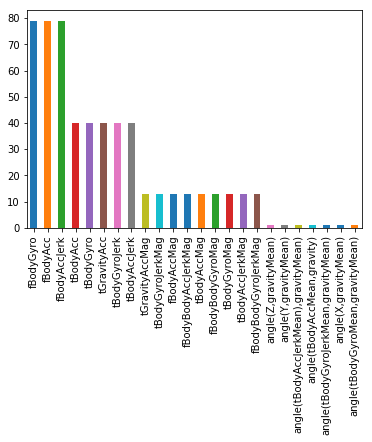

In [84]:
import matplotlib.pyplot

header_barplot= df_header.toPandas()                    # converted to pandas since easier, RDD tricky
header_barplot['Main'].value_counts().plot(kind='bar')  #Visualize Main Variable count
                                                        #Kevin

# Look for class imbalance

In [85]:
#count the number of activites done
y_train_summary=train_y.groupBy('position').count()      
y_train_summary.count()     # total activities                                                  #kevin

6

In [86]:
#look for class imbalance in how much each activity was done.
y_train_summary.show()

+--------+-----+
|position|count|
+--------+-----+
|       6| 1528|
|       5| 1523|
|       1| 1387|
|       3| 1110|
|       2| 1246|
|       4| 1420|
+--------+-----+



In [87]:
y_train_summary_dist = y_train_summary.orderBy('count', ascending = False)
y_train_summary_dist.show()

+--------+-----+
|position|count|
+--------+-----+
|       6| 1528|
|       5| 1523|
|       4| 1420|
|       1| 1387|
|       2| 1246|
|       3| 1110|
+--------+-----+



In [88]:
# add a column for proportion
sum_counts = train_y.count()
y_train_summary_dist.withColumn('Frequency (%)', F.round(y_train_summary_dist[1]/sum_counts * 100, 2)).show()


+--------+-----+-------------+
|position|count|Frequency (%)|
+--------+-----+-------------+
|       6| 1528|         18.6|
|       5| 1523|        18.54|
|       4| 1420|        17.29|
|       1| 1387|        16.89|
|       2| 1246|        15.17|
|       3| 1110|        13.51|
+--------+-----+-------------+



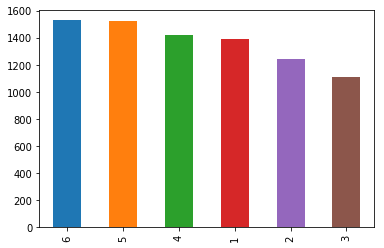

In [89]:
y_train_barplot= train_y.toPandas()                    # converted to pandas since easier, RDD tricky
y_train_barplot['position'].value_counts().plot(kind='bar')      #maybe nicer if we change x axis to display activity label?

In [90]:
y_test_summary=df_test_labels.groupBy('position').count()       #0 is column name
y_test_summary.count()     # total activities 

6

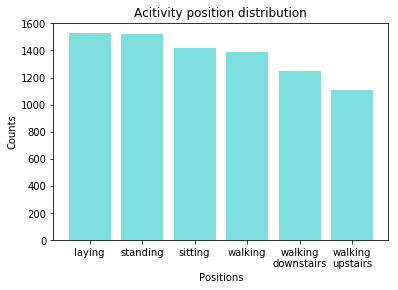

In [91]:
import matplotlib.pyplot
y_train_bar=y_train_barplot['position'].value_counts() #data read
increment=[1,2,3,4,5,6]
names=['laying','standing','sitting','walking','walking\ndownstairs','walking\nupstairs']
matplotlib.pyplot.bar(increment, y_train_bar, align='center', alpha=0.5, color='c') #Barplot
matplotlib.pyplot.xticks(increment,names)
matplotlib.pyplot.ylabel('Counts')
matplotlib.pyplot.xlabel('Positions')
matplotlib.pyplot.title('Acitivity position distribution')
matplotlib.pyplot.show()

#how are the positiosn distributed?

In [92]:
y_test_summary.show()

+--------+-----+
|position|count|
+--------+-----+
|       6|  537|
|       5|  532|
|       1|  496|
|       3|  420|
|       2|  471|
|       4|  491|
+--------+-----+



In [93]:
y_test_summary.orderBy('count', ascending=False).show()      #ordered from biggest to smallest
                                                            # kevin

+--------+-----+
|position|count|
+--------+-----+
|       6|  537|
|       5|  532|
|       1|  496|
|       4|  491|
|       2|  471|
|       3|  420|
+--------+-----+



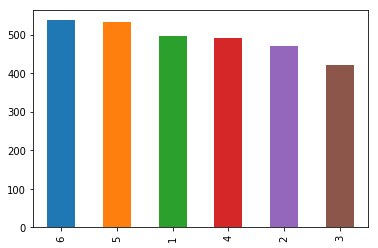

In [94]:
y_test_barplot= df_test_labels.toPandas()                    # converted to pandas since easier, RDD tricky
y_test_barplot['position'].value_counts().plot(kind='bar')     #Kevin
Y_test_bar=y_test_barplot['position'].value_counts()

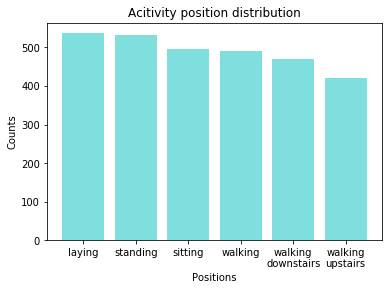

In [95]:
increment=[1,2,3,4,5,6]
names=['laying','standing','sitting','walking','walking\ndownstairs','walking\nupstairs']
matplotlib.pyplot.bar(increment, Y_test_bar, align='center', alpha=0.5, color='c') #Barplot
matplotlib.pyplot.xticks(increment,names)
matplotlib.pyplot.ylabel('Counts')
matplotlib.pyplot.xlabel('Positions')
matplotlib.pyplot.title('Acitivity position distribution')
matplotlib.pyplot.show()


# Outlier Detection, Using Interquartile Range Method

In [ ]:
cols = [c for c in train_x.columns]   # exclude id from features
bounds = {} # will store lower and upper bounds for each feature              #Will use later, -Kevin

In [ ]:
#this takes a while to run
for col in cols:
    quantiles = train_x.approxQuantile(col, [0.25, 0.75], 0.05)    #creating desired quantiles in data,
    IQR = quantiles[1] - quantiles[0]

    bounds[col] = [
     quantiles[0] - 1.5 * IQR,
     quantiles[1] + 1.5 * IQR
    ]

In [ ]:
bounds     #bounds for IQR, lower bound at .25 and upper bound at .75

In [ ]:
# append outlier indicators to data table
#code from preprocessing tutorial, added ".cast("int"), 0 is false aka no outlier, 1 indicates outlier

outliers = train_x.select(*['id'] + [
 (
 (train_x[c] < bounds[c][0]) | (train_x[c] > bounds[c][1]))
    .cast("int").alias(c + '_outlier') for c in cols
])

In [ ]:
#sums takes the sum of each column in the outliers df, since 1 indicates outlier
sums = [F.sum(x).alias(str(x)) for x in outliers.columns]
df_totaloutliers = outliers.select(sums).collect()[0] #assocites each column name to its sum
df_totaloutliers